In [24]:
import numpy as np
import cv2

data=[]
for i in range(10):
    img = cv2.imread('dataset/%s.jpg' %i)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    (threshi, final_img) = cv2.threshold(img_gray, 0, 1, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    data.append(np.array(final_img, dtype=np.float32).flatten())



In [25]:
import torch
from torch.autograd import Variable

In [26]:
x_data = Variable(torch.Tensor([data]))
y_data = Variable(torch.Tensor([data]))
 
class Perceptron(torch.nn.Module):
 
    def __init__(self):
        super(Perceptron, self).__init__()
        self.linear = torch.nn.Linear(256, 256)  # One in and one out
        self.sigmoid = torch.nn.Sigmoid()
    def forward(self, x):
        out = self.linear(x)
        out = self.sigmoid(out)
        return out
 
# our model
our_model = Perceptron()
 
criterion = torch.nn.MSELoss(size_average = False)
optimizer = torch.optim.SGD(our_model.parameters(), lr = 0.01)
 
for epoch in range(1000):
 
    # Forward pass: Compute predicted y by passing
    # x to the model
    pred_y = our_model(x_data)
 
    # Compute and print loss
    loss = criterion(pred_y, y_data)
 
    # Zero gradients, perform a backward pass,
    # and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print('epoch {}, loss {}'.format(epoch, loss.item()))
 


epoch 0, loss 699.7570190429688
epoch 1, loss 164.7550811767578
epoch 2, loss 152.83444213867188
epoch 3, loss 149.1336669921875
epoch 4, loss 145.8014373779297
epoch 5, loss 145.51394653320312
epoch 6, loss 138.1825408935547
epoch 7, loss 138.54803466796875
epoch 8, loss 132.02191162109375
epoch 9, loss 133.68606567382812
epoch 10, loss 127.2547607421875
epoch 11, loss 128.0659637451172
epoch 12, loss 120.84259033203125
epoch 13, loss 123.65877532958984
epoch 14, loss 117.7110824584961
epoch 15, loss 120.442138671875
epoch 16, loss 111.17573547363281
epoch 17, loss 112.6406478881836
epoch 18, loss 106.76163482666016
epoch 19, loss 109.75558471679688
epoch 20, loss 101.86593627929688
epoch 21, loss 102.30484008789062
epoch 22, loss 96.79061889648438
epoch 23, loss 100.57319641113281
epoch 24, loss 92.56282806396484
epoch 25, loss 92.07472229003906
epoch 26, loss 85.93659973144531
epoch 27, loss 87.8724594116211
epoch 28, loss 81.23186492919922
epoch 29, loss 80.98011779785156
epoch 30,

In [27]:
p = our_model(Variable(torch.Tensor([data[9]]))).cpu().detach().numpy()
p = p.reshape(16, 16)
p[p <= 0.5] = 0
p[p > 0.5] = 1
p

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1.,

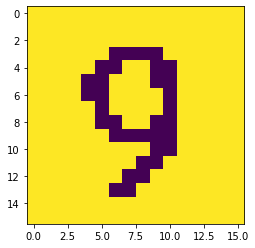

In [28]:
import matplotlib.pyplot as plt
plt.imshow(p)